In [1]:
import numpy as np
import pandas as pd 

import re

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
import plotly.graph_objects as go


In [2]:
df = pd.read_csv('/home/enno/uni/SS23/thesis/data/hendecads/stretches_w_groups.csv')
df['stretch_ix'] = df['stretch_ix'].apply(lambda x: list(map(int, x.strip('[]').split(','))))

df.head()

,Unnamed: 0,id,seq,stretch_ix,stretch_seq,avg_cc,group_id
0,0,MCD6041253.1,Mrlvyvavaailcsfsttslagaektakragkfvektatragkfve...,"[1, 71]",rlvyvavaailcsfsttslagaektakragkfvektatragkfver...,0.001041,unassigned
1,1,MCD7737945.1,MQGRVFFREAAALILAAALSMAGLPASAAANSGIEAAALRTeeete...,"[41, 238]",eeetepstkeavqetavetdtgekpesgedgqeesaesteeeqeed...,0.000364,unassigned
2,2,MYF28459.1,Merlqtdllkeihalrgemhaefasvrqemhagfasirqemhaeta...,"[1, 73]",erlqtdllkeihalrgemhaefasvrqemhagfasirqemhaetas...,0.001002,unassigned
3,3,WP_168920948.1,MSDVFLTASYADREKVKTLGARWNPAEKRWYVPSGRDLSPFAAWLP...,"[437, 540]",aqslvveikhaasqqlllarhvvparmaevtaegrqalrtakaqsq...,0.000689,group_42
4,4,WP_026306873.1,MLLRRIARPLLSAAFIAEGIDILQNPGPLADRLSPALDFTRRRSQH...,"[172, 342]",slgwrgrraardakdhaealaataaaiaatarergtnlvdtarert...,0.000424,group_38


In [32]:
groups = df['group_id'].unique()
group_dict = {group: i for i, group in enumerate(groups)}

df['group_ix'] = df['group_id'].apply(lambda x: group_dict[x])
df

,Unnamed: 0,id,seq,stretch_ix,stretch_seq,avg_cc,group_id,1R,2R,3R,4R,5R,6R,7R,8R,9R,10R,group_ix
0,0,MCD6041253.1,Mrlvyvavaailcsfsttslagaektakragkfvektatragkfve...,"[1, 71]",rlvyvavaailcsfsttslagaektakragkfvektatragkfver...,0.001041,unassigned,0.833333,0.666667,0.500000,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0
1,1,MCD7737945.1,MQGRVFFREAAALILAAALSMAGLPASAAANSGIEAAALRTeeete...,"[41, 238]",eeetepstkeavqetavetdtgekpesgedgqeesaesteeeqeed...,0.000364,unassigned,0.058824,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0
2,2,MYF28459.1,Merlqtdllkeihalrgemhaefasvrqemhagfasirqemhaeta...,"[1, 73]",erlqtdllkeihalrgemhaefasvrqemhagfasirqemhaetas...,0.001002,unassigned,0.833333,0.666667,0.500000,1.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0
3,3,WP_168920948.1,MSDVFLTASYADREKVKTLGARWNPAEKRWYVPSGRDLSPFAAWLP...,"[437, 540]",aqslvveikhaasqqlllarhvvparmaevtaegrqalrtakaqsq...,0.000689,group_42,0.666667,0.500000,0.333333,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,1
4,4,WP_026306873.1,MLLRRIARPLLSAAFIAEGIDILQNPGPLADRLSPALDFTRRRSQH...,"[172, 342]",slgwrgrraardakdhaealaataaaiaatarergtnlvdtarert...,0.000424,group_38,0.800000,0.714286,0.800000,0.333333,0.333333,0.5,0.0,0.0,0.0,0.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40585,40585,XP_034013580.1,MKLNWLLGILPIVAANFDDWSKADLTQFLEDRNVTVQKGDDLVQLA...,"[667, 798]",kdakksgesfaslasksgawyadafysvasesgesaasqalqtgqk...,0.000553,group_106,0.545455,0.200000,0.333333,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,71
40586,40586,GFR06050.1,MSDVYMDDLLTGADDLESGRKLQEQLVSLLRGAGMELHKWSASNPL...,"[578, 680]",eqrsiseeyekirdyfkdlkiklrekftrfgqwvkgkyergleksk...,0.000696,group_9,0.333333,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,59
40587,40587,KAG2190414.1,MSSSILRASIRRNATIANKRFYSAPPPPPYAPNNQGGGNGGLFLGL...,"[65, 170]",gtltkqgevvdqkiqegkqavrdkadeakakyeqskseagqavdqk...,0.000676,unassigned,0.666667,0.500000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0
40588,40588,MBY0528383.1,MRVYCSLLASLLTCATIASQPPPLVFNGGTNSLAPRRILAAEKQET...,"[734, 833]",isaltndknrmvrknavdslgffpwdakaivpllvallsdkdsdla...,0.000714,group_1_1,0.777778,0.750000,0.666667,0.500000,1.000000,1.0,0.0,0.0,0.0,0.0,5


## Dictionaries and Utils

In [3]:
aa_dict = {'r': '+',
           'h': '+',
           'k': '+',
           'd': '-',
           'e': '-',
           's': 'polar',
           't': 'polar',
           'n': 'polar',
           'q': 'polar',
           'c': 'special',
           'u': 'special',
           'g': 'special',
           'p': 'special',
           'a': 'hydrophobic',
           'v': 'hydrophobic',
           'i': 'hydrophobic',
           'l': 'hydrophobic',
           'm': 'hydrophobic',
           'f': 'hydrophobic',
           'y': 'hydrophobic',
           'w': 'hydrophobic',
           'x': 'padding'}

aa_num_dict = {'r': 0,
               'h': 0,
               'k': 0,
               'd': 1,
               'e': 1,
               's': 2,
               't': 2,
               'n': 2,
               'q': 2,
               'c': 3,
               'u': 3,
               'g': 3,
               'p': 3,
               'a': 4,
               'v': 4,
               'i': 4,
               'l': 4,
               'm': 4,
               'f': 4,
               'y': 4,
               'w': 4,
               'x': 5}

color_dict = {'+': '#00A012',           # green  
              '-': '#D81B60',           # red
              'polar': '#FFC107',       # yellow
              'hydrophobic': '#1E88E5', # blue    
              'special': '#ADADAD',     # grey
              'padding': '#FFFFFF'}     # white 

color_num_dict = {0: '#00A012',           # green
                  1: '#D81B60',           # red
                  2: '#FFC107',           # yellow
                  3: '#1E88E5',           # blue
                  4: '#ADADAD',           # grey
                  5: '#FFFFFF'}           # white

In [4]:
# Letter code and color code for expected hendecad repeat
repeat = ['A', '*', '*', 'D', 'E', '*', '*', 'H', '*', '*', '*']
color_repeat = [color_dict['hydrophobic'], color_dict['special'], color_dict['special'], color_dict['hydrophobic'], color_dict['hydrophobic'], color_dict['special'], color_dict['special'], color_dict['hydrophobic'], color_dict['special'], color_dict['special'], color_dict['special']]

## Visual

In [85]:
def plot_eleven_repeat(seq_id, seq, n_shift=0, save=False):
    seq = seq[n_shift:]
    
    n = len(seq)
    q = n // 11
    r = n % 11

    positions = [repeat[i%11] for i in range(len(seq))]
    colors = [color_dict[aa_dict[aa]] for aa in seq]
    
    # pad last hendecad with padding color
    if n % 11 != 0:
        positions += ['x'] * (11 - r)
        colors += [color_dict['padding']] * (11 - r)
    
    fig, axes = plt.subplots(q+1, 1, figsize=(6, q/3))

    first = True
    for ax in axes:
        
        if first:
            ax.set_title(seq_id) 
            first = False
        
        ax.bar(np.arange(11), np.ones(11), color=colors[:11], edgecolor='black')
        ax.set_yticks([])
        ax.set_xticks([])
        
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        
        colors = colors[11:]
        positions = positions[11:]

    ax.set_xticks(np.arange(11))
    ax.set_xticklabels(repeat)

    legend_elements = [Patch(facecolor=color_dict[aa], edgecolor='black', label=aa) for aa in color_dict.keys()]
    plt.legend(handles=legend_elements, loc='right', bbox_to_anchor=(1.33, q-2))
    
    if save:
        plt.savefig(f'/home/enno/uni/SS23/thesis/seq_analysis/plots/{seq_id}.png', bbox_inches='tight')
        plt.clf()
    else:
        plt.show()

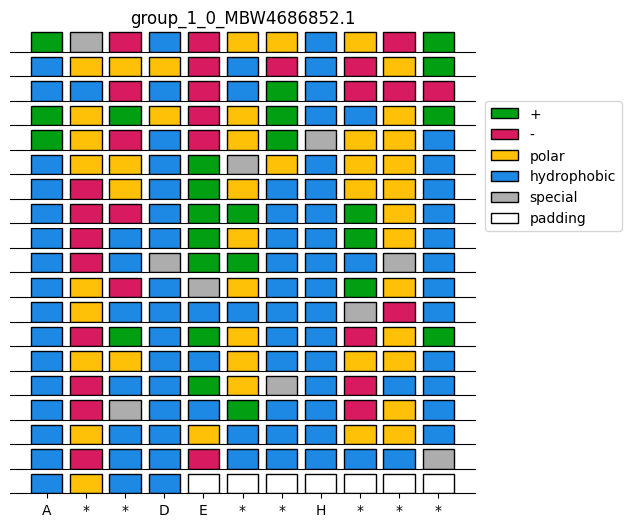

In [98]:
current_group = 'group_1_0'
n_samples = 1

tmp_df = df[df['group_id'] == current_group].sample(n_samples)[['id', 'stretch_seq']]

for i, row in tmp_df.iterrows():
    plot_eleven_repeat(current_group + '_' + row['id'], row['stretch_seq'])  # , save=True)

## RegEx

In [99]:
def find_repeat(seq, pattern, len_pattern):
    # max_s1 is the maximum number of repeats in one reading frame
    # ! searches patterns in all reading frames

    max_s1 = len(seq) // len_pattern
    return len(re.findall(pattern, seq)), max_s1

In [ ]:
# 1  2  3  4  5  6  7  8  9 10 11
# a  b  c  d  e  f  g  h  i  j  k 

# pattern = r'[avilm].{6}[avilm].{3}' # detects a------h---

# loop to find increasing number of consecutive hendecad repeats
for n in range(1, 11):
    
    pattern = r'[avilm].{2}[avilm].{3}[avilm].{3}' * n # detects a--d---h---
    len_pattern = 11 * n

    res = []

    for i in range(len(df)):
        x, y = find_repeat(df.loc[i, 'stretch_seq'], pattern, len_pattern)
        
        if y == 0:
            res.append(0)
        else:    
            res.append(x/y)

    df[f'{n}R'] = res

### Histograms

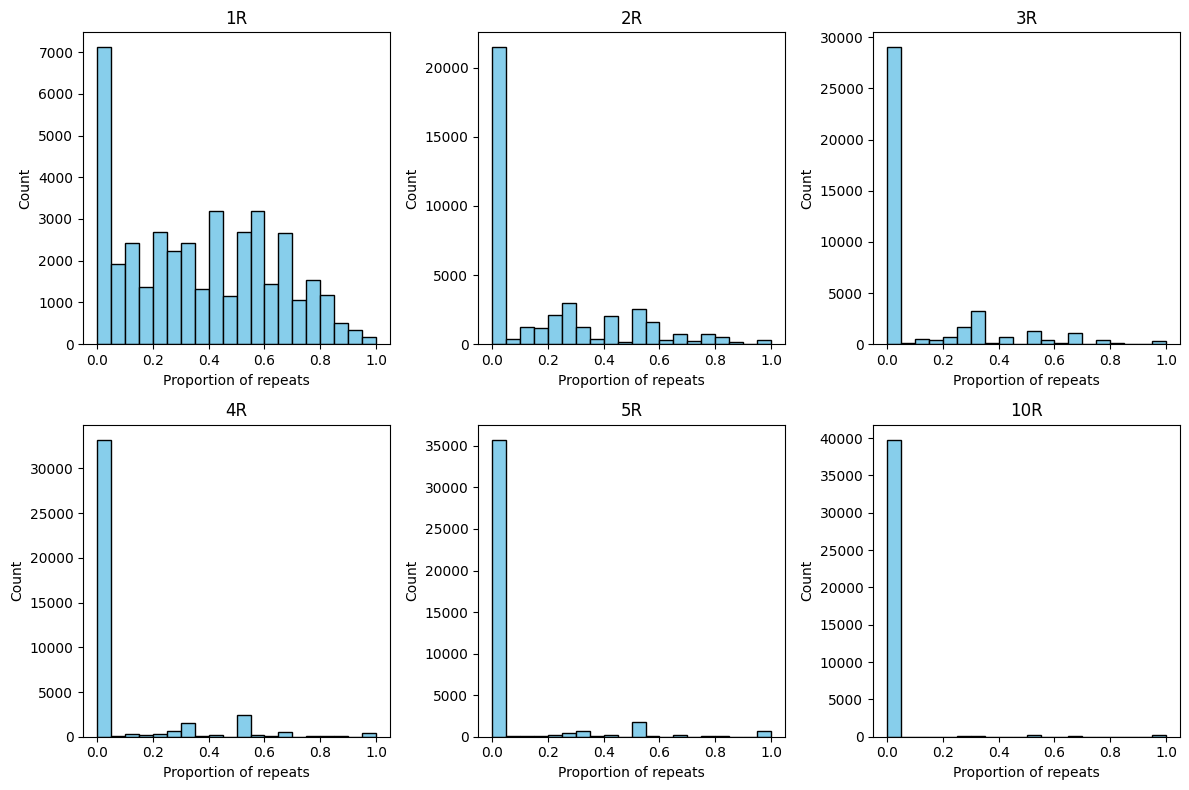

In [51]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

R = ['1', '2', '3', '4', '5', '10']

for i, ax in zip(R, axes.flat):
    ax.hist(df[f'{i}R'], bins=20, color='skyblue', edgecolor='black')
    ax.set_title(f'{i}R')
    ax.set_xlabel('Proportion of repeats')
    ax.set_ylabel('Count')

plt.tight_layout()
plt.show()


In [10]:
df

,Unnamed: 0,id,seq,stretch_ix,stretch_seq,avg_cc,group_id,1R,2R,3R,4R,5R,6R,7R,8R,9R,10R
0,0,MCD6041253.1,Mrlvyvavaailcsfsttslagaektakragkfvektatragkfve...,"[1, 71]",rlvyvavaailcsfsttslagaektakragkfvektatragkfver...,0.001041,unassigned,0.833333,0.666667,0.500000,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0
1,1,MCD7737945.1,MQGRVFFREAAALILAAALSMAGLPASAAANSGIEAAALRTeeete...,"[41, 238]",eeetepstkeavqetavetdtgekpesgedgqeesaesteeeqeed...,0.000364,unassigned,0.058824,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
2,2,MYF28459.1,Merlqtdllkeihalrgemhaefasvrqemhagfasirqemhaeta...,"[1, 73]",erlqtdllkeihalrgemhaefasvrqemhagfasirqemhaetas...,0.001002,unassigned,0.833333,0.666667,0.500000,1.000000,1.000000,0.0,0.0,0.0,0.0,0.0
3,3,WP_168920948.1,MSDVFLTASYADREKVKTLGARWNPAEKRWYVPSGRDLSPFAAWLP...,"[437, 540]",aqslvveikhaasqqlllarhvvparmaevtaegrqalrtakaqsq...,0.000689,group_42,0.666667,0.500000,0.333333,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
4,4,WP_026306873.1,MLLRRIARPLLSAAFIAEGIDILQNPGPLADRLSPALDFTRRRSQH...,"[172, 342]",slgwrgrraardakdhaealaataaaiaatarergtnlvdtarert...,0.000424,group_38,0.800000,0.714286,0.800000,0.333333,0.333333,0.5,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40585,40585,XP_034013580.1,MKLNWLLGILPIVAANFDDWSKADLTQFLEDRNVTVQKGDDLVQLA...,"[667, 798]",kdakksgesfaslasksgawyadafysvasesgesaasqalqtgqk...,0.000553,group_106,0.545455,0.200000,0.333333,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
40586,40586,GFR06050.1,MSDVYMDDLLTGADDLESGRKLQEQLVSLLRGAGMELHKWSASNPL...,"[578, 680]",eqrsiseeyekirdyfkdlkiklrekftrfgqwvkgkyergleksk...,0.000696,group_9,0.333333,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
40587,40587,KAG2190414.1,MSSSILRASIRRNATIANKRFYSAPPPPPYAPNNQGGGNGGLFLGL...,"[65, 170]",gtltkqgevvdqkiqegkqavrdkadeakakyeqskseagqavdqk...,0.000676,unassigned,0.666667,0.500000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
40588,40588,MBY0528383.1,MRVYCSLLASLLTCATIASQPPPLVFNGGTNSLAPRRILAAEKQET...,"[734, 833]",isaltndknrmvrknavdslgffpwdakaivpllvallsdkdsdla...,0.000714,group_1_1,0.777778,0.750000,0.666667,0.500000,1.000000,1.0,0.0,0.0,0.0,0.0


### Sankey

In [100]:
R = [1, 2, 5, 10]

values = []

groups_r = []
groups_not_r = []

first = True

for i in R:
  
    if first:
        r = df[(df[f'{i}R'] > 0)]       # where there is at least one pattern match
        not_r = df[(df[f'{i}R'] == 0)]  # where there is no pattern match

        groups_r.append(r)

        values.append(len(r))  
        values.append(len(not_r))    
        
        first = False
    else:
        r = df[df[f'{i}R'] > 0]                                 # where there is at least one pattern match
        not_r = df[(df[f'{i-1}R'] > 0) & (df[f'{i}R'] == 0)]    # where there is a pattern match in the previous iteration but not in the current

        groups_r.append(r)

        values.append(len(r))
        values.append(len(not_r))

In [101]:
labels = [[f'{i}R', f'not {i}R']for i in R]
labels = [item for sublist in labels for item in sublist]

color = ['#0f6349'] * len(labels)

fig = go.Figure(
    data=[
        go.Sankey(
            node=dict(
                pad=15,
                thickness=20,
                line=dict(color="black", width=0.5),
                label=["All"] + labels,
                color=color,
            ),
            link=dict(
                source=[0, 0, 1, 1, 3, 3, 5],  # , 5, 7, 7, 9, 9, 11, 11, 13, 13, 15, 15, 17, 17],
                target=[1, 2, 3, 4, 5, 6, 7],  # , 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
                value=values,
            ),
        )
    ]
)

# i = 0
# for l, v in zip(['All'] + labels, values):
#     print(f'{i} : {l} : {v}')
#     i += 1

fig.show()

### Pie Charts

group_ix
0    20342
3     5807
8     1962
5      572
4      490
Name: count, dtype: int64


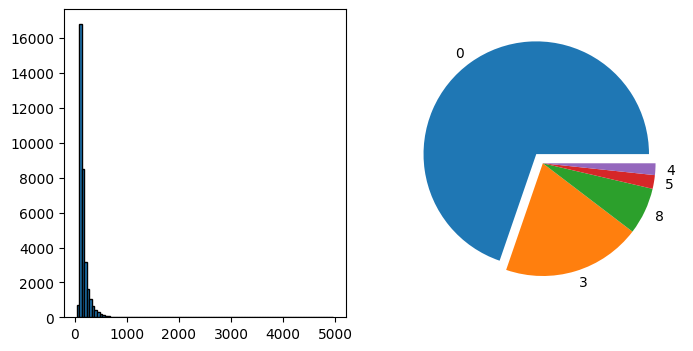

group_ix
0     10637
3      4953
5       455
4       432
20      230
Name: count, dtype: int64


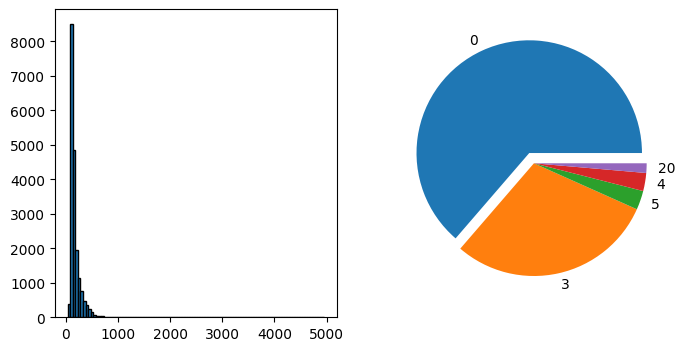

group_ix
0     2675
3     1607
4       99
5       52
38      48
Name: count, dtype: int64


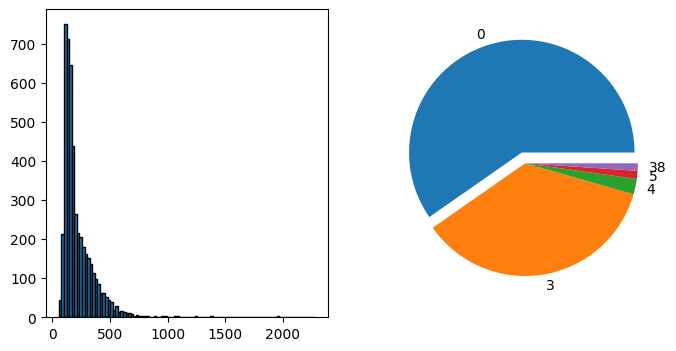

group_ix
0     391
3     365
4       9
39      9
38      7
Name: count, dtype: int64


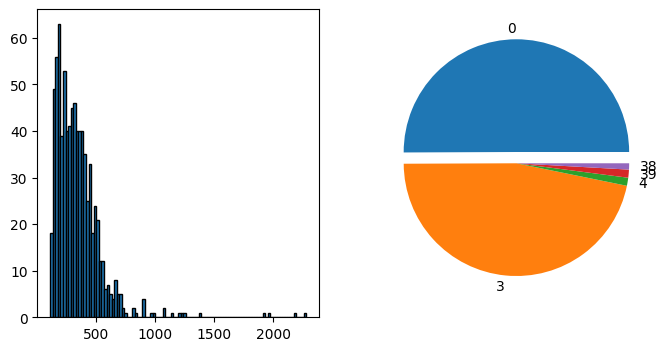

In [103]:
# display all pie charts from groups_r 
top_n = 5

for group in groups_r:
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))

    ax[0].hist(group['stretch_seq'].apply(lambda x: len(x)), bins=100, edgecolor='black')
    ax[1].pie(group['group_ix'].value_counts()[:top_n], labels=group['group_ix'].value_counts().index[:top_n], 
            explode=[0.1] + [0 for _ in range(len(group['group_ix'].unique()) - 1)][:top_n-1])

    print(group['group_ix'].value_counts()[:top_n])
    plt.show()

In [49]:
group_dict

{'unassigned': 0,
 'group_42': 1,
 'group_38': 2,
 'group_0': 3,
 'group_1_0': 4,
 'group_1_1': 5,
 'group_58': 6,
 'group_2': 7,
 'group_1_2': 8,
 'group_102': 9,
 'group_21': 10,
 'group_31': 11,
 'group_3': 12,
 'group_84': 13,
 'group_14': 14,
 'group_5': 15,
 'group_85': 16,
 'group_25': 17,
 'group_39': 18,
 'group_19': 19,
 'group_4': 20,
 'group_59': 21,
 'group_73': 22,
 'group_15': 23,
 'group_8': 24,
 'group_86': 25,
 'group_66': 26,
 'group_34': 27,
 'group_1_3': 28,
 'group_113': 29,
 'group_10': 30,
 'group_30': 31,
 'group_51': 32,
 'group_114': 33,
 'group_17': 34,
 'group_27': 35,
 'group_11': 36,
 'group_23': 37,
 'group_12': 38,
 'group_6': 39,
 'group_77': 40,
 'group_7': 41,
 'group_28': 42,
 'group_94': 43,
 'group_1_4': 44,
 'group_78': 45,
 'group_35': 46,
 'group_55': 47,
 'group_103': 48,
 'group_67': 49,
 'group_60': 50,
 'group_68': 51,
 'group_26': 52,
 'group_43': 53,
 'group_24': 54,
 'group_74': 55,
 'group_63': 56,
 'group_87': 57,
 'group_104': 58,
 'g

In [83]:
# calculate the frequency of each amino acid in the hendecad repeat
group_4 = groups_r[-1]['stretch_seq']

aa_freq = {aa: 0 for aa in aa_dict.keys()}
total = 0

for seq in group_4:
    for aa in seq:
        aa_freq[aa] += 1
        total += 1

aa_freq = {aa: freq/total for aa, freq in aa_freq.items()}
aa_freq = dict(sorted(aa_freq.items(), key=lambda x: x[1], reverse=True))

aa_freq


{'a': 0.13707003172668447,
 'l': 0.12070479843696787,
 'v': 0.0975891304737493,
 'i': 0.09278173116564198,
 'g': 0.06899568015200129,
 's': 0.06712792844467548,
 't': 0.0589399343956694,
 'e': 0.051723458029360625,
 'd': 0.043040742798759614,
 'k': 0.04300130850167596,
 'q': 0.03937693810607826,
 'n': 0.035616340138737025,
 'p': 0.035282941081575224,
 'f': 0.025944182544946136,
 'm': 0.02591191812005951,
 'r': 0.02185377045654161,
 'y': 0.010174048647582857,
 'w': 0.009751026187958199,
 'h': 0.008826112674541576,
 'c': 0.006287977916793633,
 'u': 0.0,
 'x': 0.0}

In [119]:
import numpy as np
from scipy.stats import chisquare, entropy

total = list(total_aa_freq.values())[:-2]
observed = list(aa_freq.values())[:-2]

kl_divergence = entropy(pk=observed, qk=total)

chi2, p_value = chisquare(observed, total)

print(f"KL divergence: {kl_divergence}")
print(f"Chi-Squared p-value: {p_value}")

KL divergence: 0.025551928598402544
Chi-Squared p-value: 1.0


### Sequence Properties

In [126]:
# compute amino acid frequency for all groups
total_aa_freq = {aa: 0 for aa in aa_dict.keys()}
total = 0

property_df = pd.DataFrame(columns=[['group'] +  
                                    list(aa_dict.keys()) +
                                    ['mean_length', 'std_length']])

print(property_df)

groups = df['group_id'].unique()
for group in groups:
    group_df = df[df['group_id'] == group]
    
    aa_freq = {aa: 0 for aa in aa_dict.keys()}
    total = 0

    for seq in group_df['stretch_seq']:
        for aa in seq:
            aa_freq[aa] += 1
            total += 1

    aa_freq = {aa: freq/total for aa, freq in aa_freq.items()}
    # aa_freq = dict(sorted(aa_freq.items(), key=lambda x: x[1], reverse=True))
    
    mean_length = group_df['stretch_seq'].apply(lambda x: len(x)).mean()
    std_length = group_df['stretch_seq'].apply(lambda x: len(x)).std()
    
    total_aa_freq = {aa: total_aa_freq[aa] + aa_freq[aa] for aa in aa_dict.keys()}
    
    property_df.loc[len(property_df)] = {'group': group, **aa_freq, 'mean_length': mean_length, 'std_length': std_length}

Empty DataFrame
Columns: [(group,), (r,), (h,), (k,), (d,), (e,), (s,), (t,), (n,), (q,), (c,), (u,), (g,), (p,), (a,), (v,), (i,), (l,), (m,), (f,), (y,), (w,), (x,), (mean_length,), (std_length,)]
Index: []

[0 rows x 25 columns]


In [127]:
property_df

,group,r,h,k,d,e,s,t,n,q,...,v,i,l,m,f,y,w,x,mean_length,std_length
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
134,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
135,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
136,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
